In [15]:
# Update this to the directory where your CSV files are stored
csv_dir = "./data/nico"  # ← CHANGE THIS

In [16]:
# === Setup Cell ===
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
from glob import glob
from collections import defaultdict

csv_files = glob(os.path.join(csv_dir, "*.csv"))

# Regex for filename parsing
pattern = re.compile(
    r"(?P<preset>cpu-parallel|cpu-serial|cuda|opencl)"
    r"-grid(?P<gridX>\d+)x(?P<gridY>\d+)"
    r"-block(?P<blockX>\d+)x(?P<blockY>\d+)"
    r"-(?P<dim>\d+)d(?P<aligned>-unaligned|)"
)

# Collect data
data = defaultdict(list)
dataNoCopy = defaultdict(list)
for file in csv_files:
    match = pattern.search(os.path.basename(file))
    if not match:
        print(f"Skipping unrecognized file format: {file}")
        continue

    groups = match.groupdict()
    preset = groups["preset"]
    gridX = int(groups["gridX"])
    gridY = int(groups["gridY"])
    blockX = int(groups["blockX"])
    blockY = int(groups["blockY"])
    dim = int(groups["dim"])
    world_size = gridX * gridY

    try:
        df = pd.read_csv(file)
        avg_cells_per_sec = df["cellsPerSecond"].mean()
        avg_cells_no_copy = df["cellsPerSecondNoCopy"].mean()
        data[(preset, blockX, blockY, dim)].append((world_size, avg_cells_per_sec))
        dataNoCopy[(preset, blockX, blockY, dim)].append((world_size, avg_cells_no_copy))
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Define preset color map
preset_colors = {
    'cpu-serial': cm.Reds,
    'cpu-parallel': cm.Blues,
    'cuda': cm.Greens,
    'opencl': cm.Purples,
}

# Get unique preset pairs
all_presets = sorted({key[0] for key in data})
preset_pairs = list(itertools.combinations(all_presets, 2))

group_counts = defaultdict(int)
for (preset, blockX, blockY, dim) in data:
    group_counts[preset] += 1

color_map = {}
preset_variants = defaultdict(list)
for key in sorted(data):
    preset, blockX, blockY, dim = key
    variant_index = len(preset_variants[preset])
    total_variants = group_counts[preset]
    cmap = preset_colors[preset]
    # Spread colors evenly, avoid extremes
    color = cmap(0.3 + 0.7 * (variant_index / max(1, total_variants - 1)))
    color_map[key] = color
    preset_variants[preset].append(key)

print(f"Prepared {len(preset_pairs)} preset pairs.")



Prepared 6 preset pairs.


In [17]:
def graph_preset_pair(preset1,preset2):
    plt.figure(figsize=(8, 5))

    for (preset, blockX, blockY, dim), values in data.items():
        if preset not in (preset1, preset2):
            continue
        variant_index = len(preset_variants[preset])
        label = f"{preset} block{blockX}x{blockY} {dim}d"
        color = color_map[(preset, blockX, blockY, dim)]
        world_sizes, avg_values = zip(*sorted(values))
        plt.plot(world_sizes, avg_values, marker='o', label=label, color=color)

    plt.title(f"{preset1} vs {preset2}")
    plt.xscale('log')
    plt.xlabel("World Size (gridX × gridY)")
    plt.ylabel("Avg Cells per Second")
    plt.grid(True)
    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.show()


In [18]:
def graph_preset_pair_no_copy(preset1,preset2):
    plt.figure(figsize=(8, 5))

    for (preset, blockX, blockY, dim), values in dataNoCopy.items():
        if preset not in (preset1, preset2):
            continue
        label = f"{preset} block{blockX}x{blockY} {dim}d"
        color = color_map[(preset, blockX, blockY, dim)]
        world_sizes, avg_values = zip(*sorted(values))
        plt.plot(world_sizes, avg_values, marker='o', label=label, color=color)

    plt.title(f"{preset1} vs {preset2} (No copy)")
    plt.xscale('log')
    plt.xlabel("World Size (gridX × gridY)")
    plt.ylabel("Avg Cells per Second")
    plt.grid(True)
    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.show()

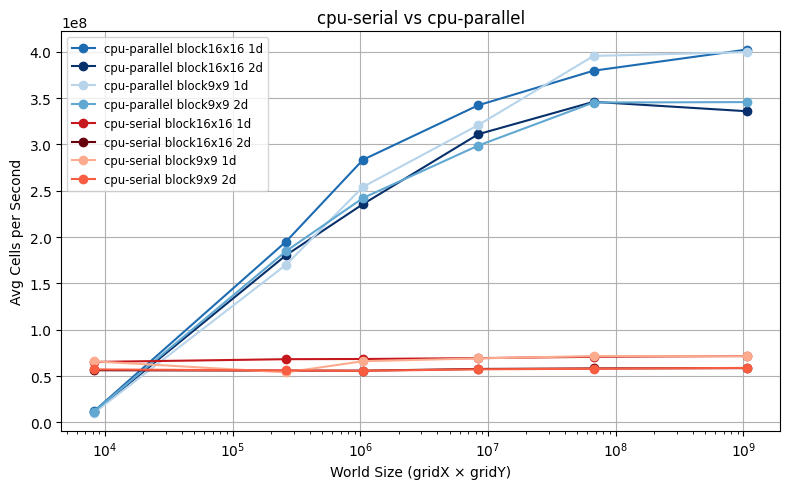

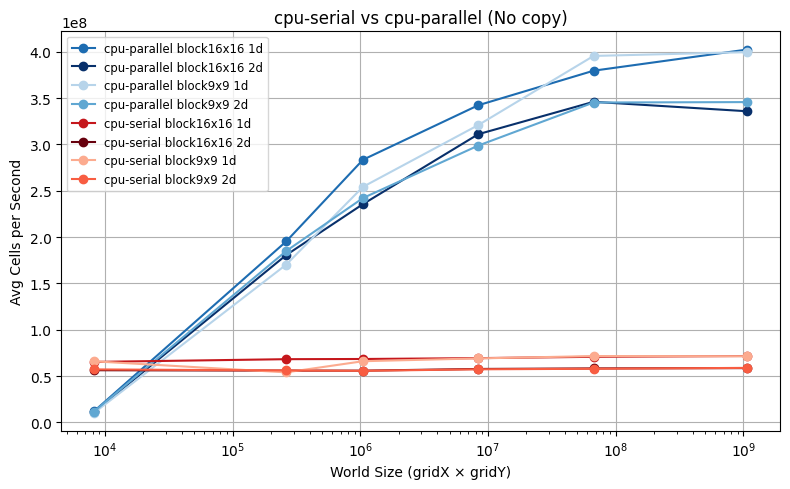

In [19]:
graph_preset_pair("cpu-serial","cpu-parallel")
graph_preset_pair_no_copy("cpu-serial","cpu-parallel")


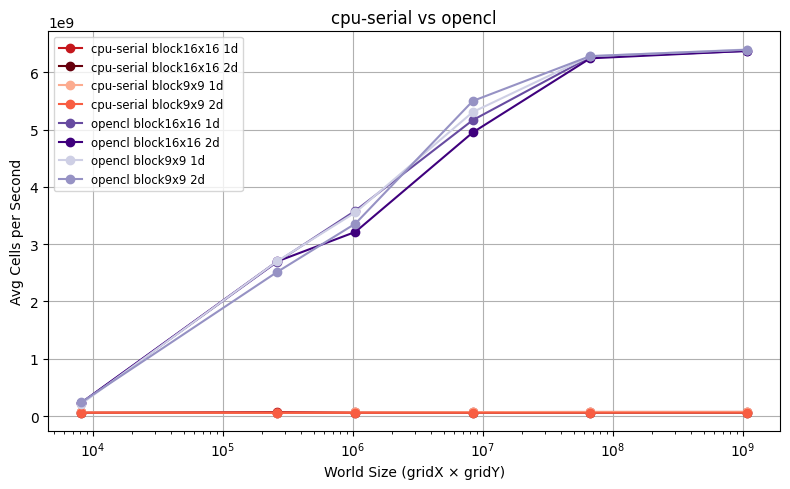

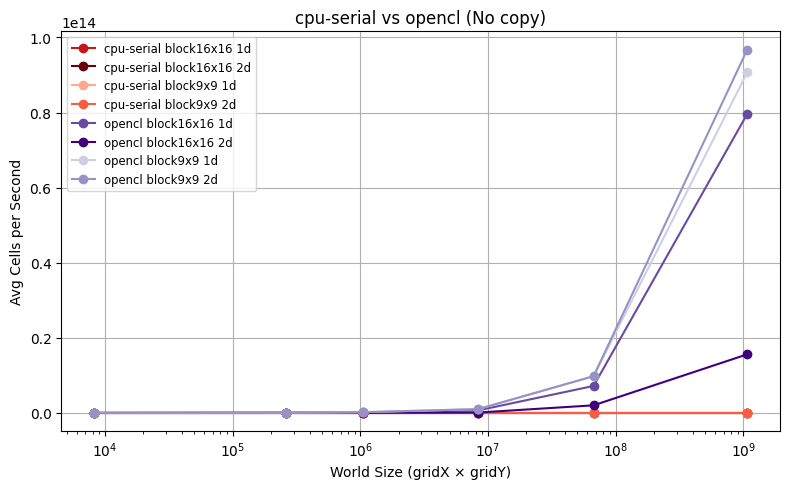

In [20]:
graph_preset_pair("cpu-serial","opencl")
graph_preset_pair_no_copy("cpu-serial","opencl")


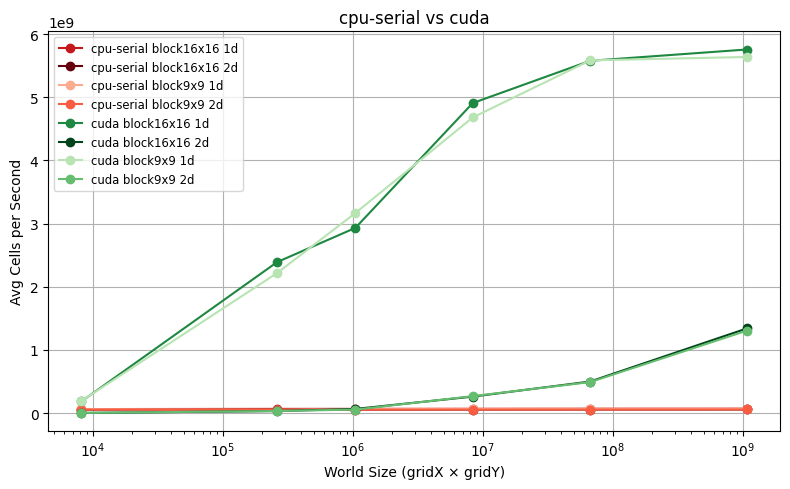

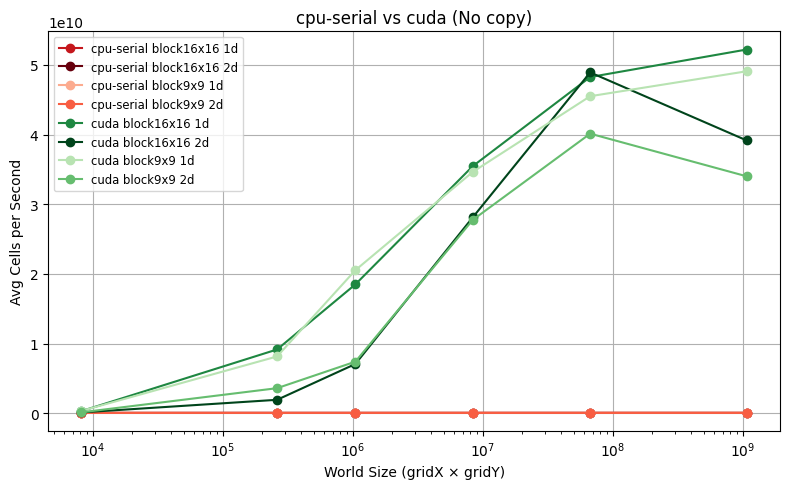

In [21]:
graph_preset_pair("cpu-serial","cuda")
graph_preset_pair_no_copy("cpu-serial","cuda")


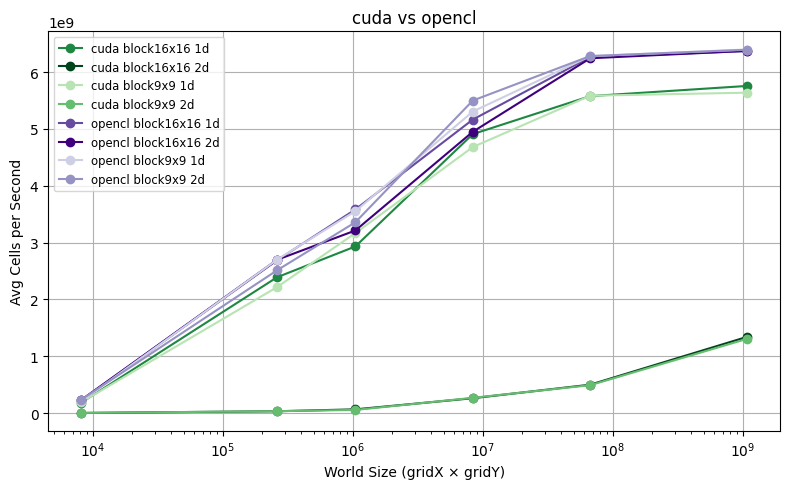

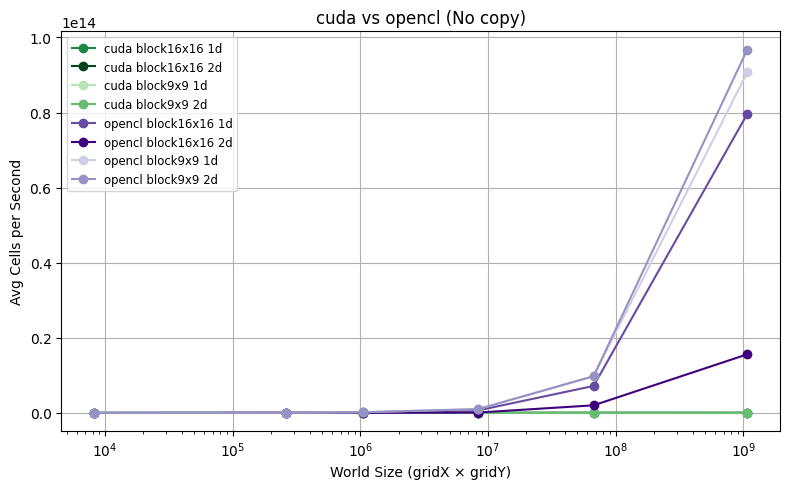

In [22]:
graph_preset_pair("cuda","opencl")
graph_preset_pair_no_copy("cuda","opencl")
